# Bayesian Logistic Regression: Quantifying Classification Uncertainty

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 9 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of classification methods, we developed logistic regression as an elegant framework for probabilistic classification. By transforming linear combinations of features through the sigmoid function or softmax function, we obtained well-calibrated probabilities for distinguishing between astronomical populations. Yet this approach, powerful as it is, provides only a single optimal decision boundary—a point estimate that captures our best guess but conceals the uncertainty inherent in finite data.

Consider the challenge of classifying a star whose spectroscopic parameters place it far from any training example. Standard logistic regression might confidently assign it to one class or another, but this confidence is unwarranted. We lack sufficient information in that region of parameter space to make definitive statements. This overconfidence becomes particularly problematic in astronomy, where misclassifications can propagate through analyses—a Red Giant Branch star mistakenly identified as a Red Clump star leads to incorrect distance estimates, potentially placing entire stellar populations at wrong locations within the Galaxy.

Bayesian logistic regression addresses these limitations through a fundamental shift in perspective. Rather than seeking a single optimal set of weights, we maintain a distribution over all plausible weight configurations consistent with our data. This distribution, the posterior, encodes both our best estimates and our uncertainty about those estimates. In regions densely populated with training data, the posterior concentrates tightly around specific weight values; in sparse regions, it remains broad, reflecting our ignorance.

The key insight is that predictions in Bayesian logistic regression integrate over this entire posterior distribution. Instead of using a single weight vector to compute $P({\rm RC}|{\bf x})$, we average predictions across all plausible weight configurations, weighted by their posterior probability. This marginalization over parameter uncertainty naturally produces more cautious predictions in regions of high uncertainty. A star might have 90% probability of being Red Clump under the most likely weights, but after integrating over weight uncertainty, the predictive distribution might yield only 75%—the remaining uncertainty reflecting our limited knowledge in that region of parameter space.

The mathematical framework builds naturally on our previous work. We augment the likelihood function from standard logistic regression with a prior distribution over weights, typically Gaussian to encode smoothness preferences. Bayes' theorem then combines these components into a posterior distribution. While this posterior lacks a closed form due to the nonlinearity of the sigmoid function, the Laplace approximation provides an accurate Gaussian approximation centered at the maximum a posteriori (MAP) estimate. The predictive distribution, obtained by marginalizing over this approximate posterior, can be computed efficiently using the probit approximation, yielding closed-form expressions that automatically incorporate parameter uncertainty into classification decisions.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Logistic Regression**: Understanding of the sigmoid function, cross-entropy loss, and gradient-based optimization from Chapter 7
- **Bayesian Inference**: Basic concepts including prior distributions, likelihood functions, and posterior inference from Chapter 2
- **Linear Algebra**: Matrix operations, eigenvalues, and quadratic forms necessary for understanding the Hessian and covariance matrices
- **Optimization Theory**: Gradient descent and the concept of convexity in optimization landscapes

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Bayesian Framework**: Extending point estimation to full posterior distributions over model parameters
- **Laplace Approximation**: Implementing second-order Taylor expansions to approximate complex posteriors with Gaussians
- **Uncertainty Quantification**: Computing and visualizing prediction uncertainty through posterior marginalization
- **Prior Specification**: Understanding how prior strength affects both parameter estimates and prediction confidence
- **Predictive Distributions**: Deriving closed-form expressions for Bayesian predictions using the probit approximation
- **Scientific Interpretation**: Connecting mathematical uncertainty to astronomical classification reliability

### Astronomical Context

We continue with the Red Clump versus Red Giant Branch classification problem from Chapter 7, but now focus on quantifying our confidence in these classifications. This uncertainty quantification proves essential when RC stars serve as distance indicators—overconfident misclassifications could systematically bias Galactic structure measurements. By maintaining distributions over possible decision boundaries rather than committing to a single boundary, we can propagate classification uncertainty through to final scientific products.


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Configure plotting parameters to match textbook style
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## Revisiting the RGB-Red Clump Classification Problem

In Chapter 7, we classified Red Clump and Red Giant Branch stars using eight spectroscopic features from APOGEE. For this exploration of Bayesian methods, we focus on the two most physically meaningful features: effective temperature and surface gravity. This dimensionality reduction serves two key purposes:

1. **Visualization**: Two-dimensional parameter spaces allow direct visualization of decision boundaries and uncertainty regions, making the concepts of posterior distributions and predictive uncertainty more intuitive.

2. **Physical Insight**: Temperature and gravity are the primary spectroscopic indicators of evolutionary state. By focusing on these features, we can better understand how uncertainty manifests in the most important physical parameters.

The fundamental classification challenge remains unchanged. Red Clump stars, burning helium in their cores, cluster tightly in temperature-gravity space. Red Giant Branch stars, ascending toward the helium flash, spread across a broader range of parameters. The populations overlap in certain regions, making probabilistic classification essential. What changes with the Bayesian approach is our ability to quantify how confident we should be in each classification, particularly in regions where training data is sparse or populations overlap.

In [43]:
# Load the APOGEE dataset
data = np.load("dataset_apogee_asteroseismic.npz")
X_full = data["data"]  # Full feature matrix
t = data["label"]      # Labels (1 for RC, 0 for RGB)

# Extract temperature and surface gravity
X = X_full[:, 0:2]

print("Dataset Characteristics:")
print(f"Number of stars: {X.shape[0]:,}")
print(f"Features used: Effective Temperature, Surface Gravity")
print(f"Red Clump stars: {np.sum(t == 1):,}")
print(f"Red Giant Branch stars: {np.sum(t == 0):,}")
print(f"Class imbalance ratio: {np.sum(t == 1)/np.sum(t == 0):.2f}")

Dataset Characteristics:
Number of stars: 2,855
Features used: Effective Temperature, Surface Gravity
Red Clump stars: 2,125
Red Giant Branch stars: 730
Class imbalance ratio: 2.91


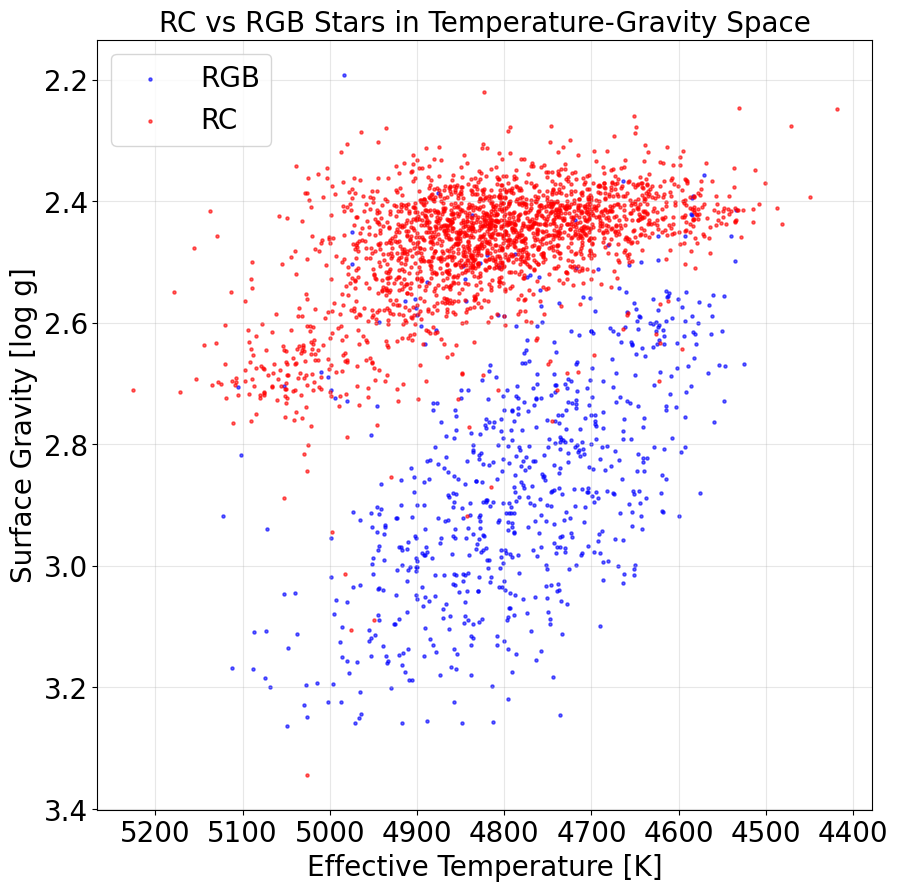

In [44]:
# Visualize the stellar populations in temperature-gravity space
plt.figure(figsize=(10, 10))

# Plot RGB stars (label = 0) in blue
plt.scatter(X[t == 0, 0], X[t == 0, 1], c='blue', s=5, alpha=0.6, label='RGB')
# Plot Red Clump stars (label = 1) in red
plt.scatter(X[t == 1, 0], X[t == 1, 1], c='red', s=5, alpha=0.6, label='RC')

# Customize the plot following astrophysical conventions
plt.gca().invert_xaxis()  # Higher temperature on the left
plt.gca().invert_yaxis()  # Lower gravity (more evolved) at top
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('RC vs RGB Stars in Temperature-Gravity Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## From Standard to Bayesian Logistic Regression

In standard logistic regression, we seek a single weight vector $\mathbf{w}$ that maximizes the likelihood of our observed data. The probability of a star being Red Clump given features $\mathbf{x}$ is modeled as:

$$P(t=1|\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x})$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function. This approach yields a point estimate—one specific decision boundary deemed optimal according to the maximum likelihood principle.

The Bayesian framework fundamentally reconceptualizes this problem. Instead of committing to a single weight vector, we maintain a probability distribution over all possible weight vectors. This posterior distribution $p(\mathbf{w}|\mathcal{D})$ represents our beliefs about the weights after observing the data $\mathcal{D}$. Bayes' theorem provides the recipe:

$$p(\mathbf{w}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}$$

The likelihood $p(\mathcal{D}|\mathbf{w})$ remains the same as in standard logistic regression—the probability of observing our stellar classifications given specific weights. The crucial addition is the prior $p(\mathbf{w})$, encoding our beliefs before seeing the data. For regularization and computational convenience, we choose a Gaussian prior:

$$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$$

This prior, centered at zero with precision $\alpha$, expresses a preference for smaller weights—a form of L2 regularization emerging naturally from Bayesian principles. Larger $\alpha$ values encode stronger beliefs that weights should be small, preventing overfitting in regions with sparse data.

The challenge arises in computing the posterior. Unlike Bayesian linear regression, where Gaussian priors and likelihoods yield Gaussian posteriors, the sigmoid function's nonlinearity precludes analytical solutions. The posterior distribution has no simple closed form, motivating approximation techniques like the Laplace approximation we'll implement.

In [45]:
def sigmoid(z):
    """
    Sigmoid activation function with numerical stability.
    
    Parameters
    ----------
    z : array
        Input values (logits)
        
    Returns
    -------
    array
        Sigmoid outputs between 0 and 1
    """
    # Clip to avoid overflow in exp()
    z = np.clip(z, -30, 30)
    return 1 / (1 + np.exp(-z))

# Normalize features for numerical stability
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Split data into training and test sets
X_train, X_test, t_train, t_test = train_test_split(
    X_norm, t, test_size=0.2, random_state=46, stratify=t
)

print(f"Training set: {len(t_train)} stars")
print(f"Test set: {len(t_test)} stars")
print(f"\nClass distribution in training set:")
print(f"RGB stars: {np.sum(t_train == 0)}")
print(f"RC stars: {np.sum(t_train == 1)}")

Training set: 2284 stars
Test set: 571 stars

Class distribution in training set:
RGB stars: 584
RC stars: 1700


## Finding the Maximum A Posteriori (MAP) Estimate

The first step in Bayesian logistic regression is finding the Maximum A Posteriori (MAP) estimate—the mode of the posterior distribution. While not fully Bayesian (as it still provides a point estimate), the MAP estimate serves as the foundation for the Laplace approximation.

The MAP estimate maximizes the posterior probability:

$$\mathbf{w}_{\text{MAP}} = \arg\max_{\mathbf{w}} p(\mathbf{w}|\mathcal{D}) = \arg\max_{\mathbf{w}} \left[\log p(\mathcal{D}|\mathbf{w}) + \log p(\mathbf{w})\right]$$

For our Gaussian prior, this becomes:

$$\mathbf{w}_{\text{MAP}} = \arg\min_{\mathbf{w}} \left[-\sum_{n=1}^N \left(t_n \log y_n + (1-t_n)\log(1-y_n)\right) + \frac{\alpha}{2}\|\mathbf{w}\|^2\right]$$

The key difference from standard logistic regression is the additional term $\frac{\alpha}{2}\|\mathbf{w}\|^2$ arising from the Gaussian prior. This term penalizes large weights, with the prior precision $\alpha$ controlling the regularization strength.

The gradient of this objective combines the data-driven gradient from the likelihood with the prior-driven gradient:

$$\nabla_{\mathbf{w}} = \sum_{n=1}^N (y_n - t_n)\mathbf{x}_n + \alpha\mathbf{w}$$

This form shows how the prior pulls weights toward zero while the data pulls them toward values that explain the observations. The balance between these forces depends on both the prior strength $\alpha$ and the amount of data—with abundant data, the likelihood dominates; with sparse data, the prior exerts stronger influence.

In [46]:
def create_mini_batches(X, t, batch_size):
    """
    Create mini-batches from data.
    
    Parameters
    ----------
    X : array
        Feature matrix
    t : array
        Target labels
    batch_size : int
        Size of each mini-batch
        
    Returns
    -------
    list
        List of (X_batch, t_batch) tuples
    """
    indices = np.random.permutation(len(t))
    n_batches = len(t) // batch_size

    mini_batches = []
    for i in range(n_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        mini_batches.append((X[batch_indices], t[batch_indices]))

    # Handle remaining samples
    if len(t) % batch_size != 0:
        batch_indices = indices[n_batches * batch_size:]
        mini_batches.append((X[batch_indices], t[batch_indices]))

    return mini_batches

def cost(w, X, t, N):
    """
    Compute negative log-likelihood cost function.
    
    Parameters
    ----------
    w : array
        Weight vector
    X : array
        Feature matrix with bias term
    t : array
        True labels (0 or 1)
    N : int
        Number of samples
        
    Returns
    -------
    float
        Average negative log-likelihood
    """
    z = X @ w
    y = sigmoid(z)
    # Add small epsilon to prevent log(0)
    epsilon = 1e-15
    return -np.sum(t * np.log(y + epsilon) + 
                   (1 - t) * np.log(1 - y + epsilon)) / N

In [47]:
def find_map_estimate(X_train, t_train, X_test, t_test, learning_rate, n_epochs, batch_size, alpha):
    """
    Find the Maximum A Posteriori (MAP) estimate for Bayesian logistic regression.
    
    Parameters
    ----------
    X_train : array
        Training feature matrix
    t_train : array
        Training targets (binary)
    X_test : array
        Test feature matrix
    t_test : array
        Test targets (binary)
    learning_rate : float
        Learning rate for gradient descent
    n_epochs : int
        Number of epochs to train
    batch_size : int
        Mini-batch size
    alpha : float
        Precision parameter for Gaussian prior
        
    Returns
    -------
    w : array
        MAP estimate of weights
    train_loss_history : list
        Training loss per epoch
    test_loss_history : list
        Test loss per epoch
    """
    N, M = X_train.shape
    w = np.random.normal(0, 0.1, M)  # Initialize weights
    train_loss_history = []
    test_loss_history = []

    print(f"Finding MAP estimate with prior precision α={alpha}...")
    
    for epoch in range(n_epochs):
        mini_batches = create_mini_batches(X_train, t_train, batch_size)

        for X_batch, t_batch in mini_batches:
            # Forward pass
            z_batch = X_batch @ w
            y_batch = sigmoid(z_batch)
            
            # Gradient of negative log-likelihood
            grad_nll = X_batch.T @ (y_batch - t_batch) / len(t_batch)
            
            # Gradient of negative log-prior
            grad_prior = alpha * w / len(t_batch)
            
            # Combined gradient
            grad_posterior = grad_nll + grad_prior
            
            # Update weights
            w = w - learning_rate * grad_posterior

        # Record losses
        train_loss = cost(w, X_train, t_train, len(t_train))
        test_loss = cost(w, X_test, t_test, len(t_test))
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    return w, train_loss_history, test_loss_history

Finding MAP estimate with prior precision α=0.1...
Epoch 0: Train Loss = 0.3810, Test Loss = 0.3956
Epoch 20: Train Loss = 0.2403, Test Loss = 0.2504
Epoch 40: Train Loss = 0.2387, Test Loss = 0.2485
Epoch 60: Train Loss = 0.2385, Test Loss = 0.2482
Epoch 80: Train Loss = 0.2386, Test Loss = 0.2483
Epoch 100: Train Loss = 0.2385, Test Loss = 0.2483
Epoch 120: Train Loss = 0.2386, Test Loss = 0.2483
Epoch 140: Train Loss = 0.2385, Test Loss = 0.2482
Epoch 160: Train Loss = 0.2385, Test Loss = 0.2482
Epoch 180: Train Loss = 0.2385, Test Loss = 0.2483


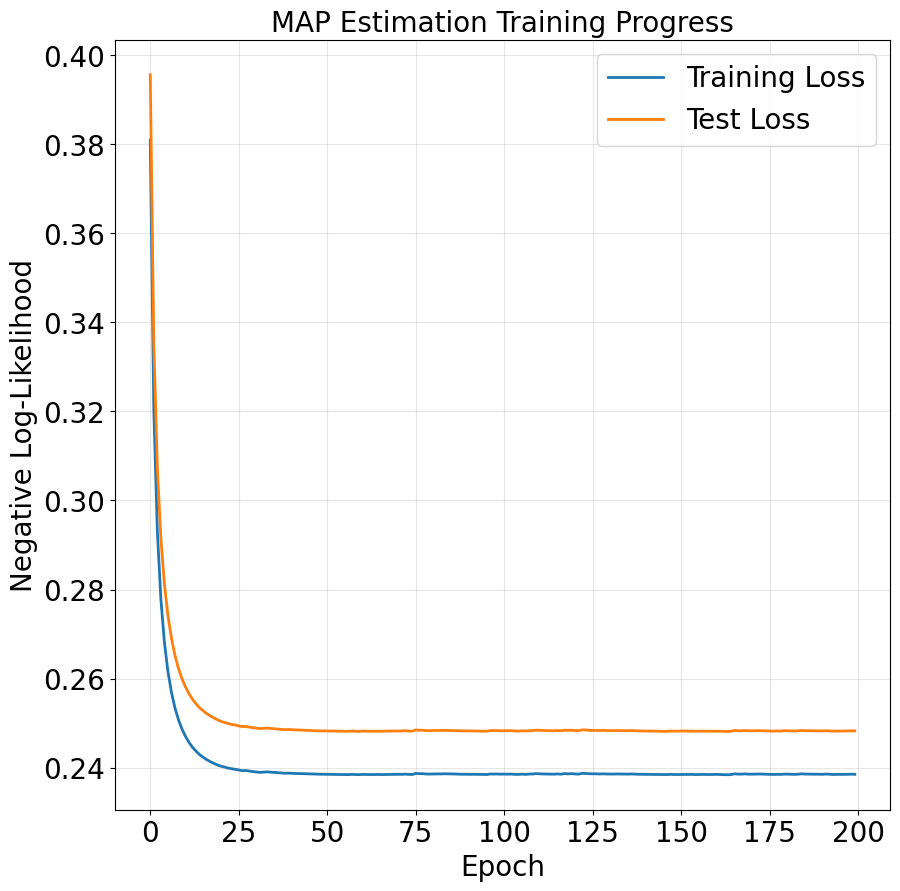


Final training loss: 0.2385
Final test loss: 0.2482


In [48]:
# Set hyperparameters
learning_rate = 0.1
n_epochs = 200
batch_size = 32
alpha = 0.1  # Prior precision parameter

# Find the MAP estimate
w_map, train_losses, test_losses = find_map_estimate(
    X_train, t_train, X_test, t_test, 
    learning_rate, n_epochs, batch_size, alpha
)

# Plot training curves
plt.figure(figsize=(10, 10))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('MAP Estimation Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal training loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")

## Visualizing the MAP Decision Boundary

With the MAP estimate in hand, we can visualize the resulting decision boundary. At this stage, we have only a point estimate—a single set of weights that maximizes the posterior probability. This provides no information about uncertainty; regions far from training data receive the same confident predictions as regions densely populated with examples.

The decision boundary occurs where the predicted probability equals 0.5, corresponding to $\mathbf{w}^T\mathbf{x} = 0$. By evaluating predictions across a grid of temperature-gravity values, we can visualize both the decision boundary and the probability contours that indicate classification confidence under the MAP estimate.


In [49]:
def predict(w, X):
    """
    Make predictions using trained weights.
    
    Parameters
    ----------
    w : array
        Weight vector
    X : array
        Feature matrix
        
    Returns
    -------
    predictions : array
        Binary predictions (0 or 1)
    probabilities : array
        Predicted probabilities
    """
    probs = sigmoid(X @ w)
    return (probs > 0.5).astype(int), probs

# Create a grid in original feature space
Teff_min, Teff_max = X[:, 0].min() - 100, X[:, 0].max() + 100
logg_min, logg_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx_orig, yy_orig = np.meshgrid(np.linspace(Teff_min, Teff_max, 100),
                              np.linspace(logg_min, logg_max, 100))

# Normalize the grid points
xx_norm = (xx_orig - X_mean[0]) / X_std[0]
yy_norm = (yy_orig - X_mean[1]) / X_std[1]
grid_points_norm = np.c_[xx_norm.ravel(), yy_norm.ravel()]

# Make predictions on the grid
grid_probs = sigmoid(grid_points_norm @ w_map)
grid_probs = grid_probs.reshape(xx_orig.shape)

# Make predictions on test set
X_test_orig = X_test * X_std + X_mean  # Convert back to original scale
test_pred, test_probs = predict(w_map, X_test)
misclassified = test_pred != t_test


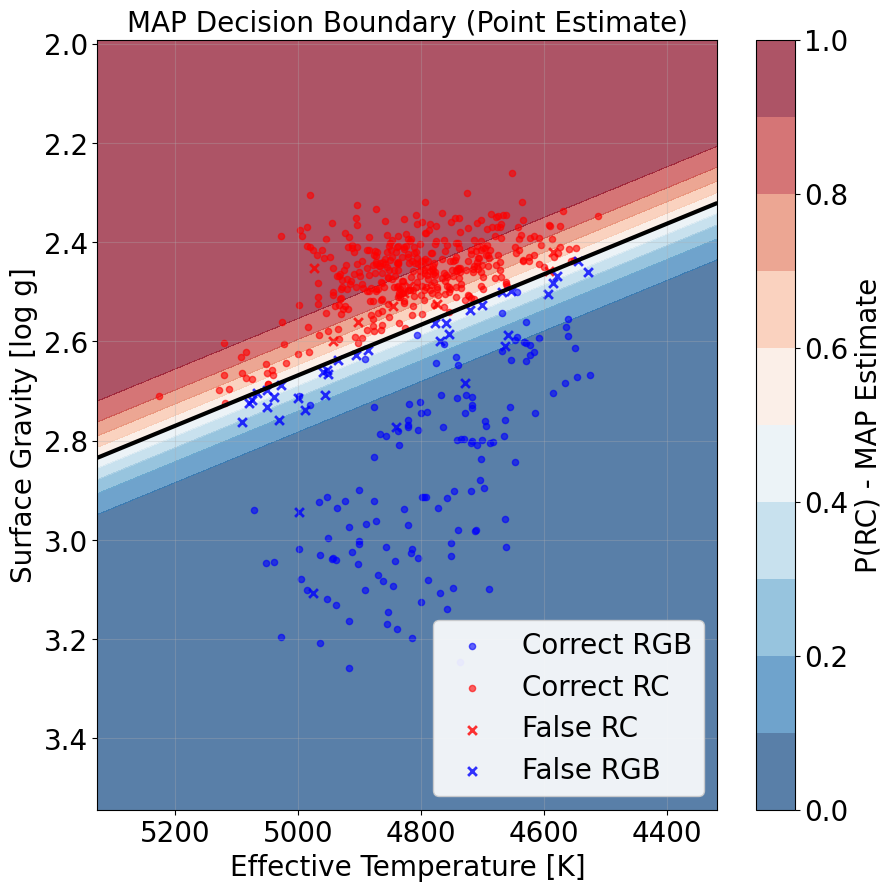

Test set accuracy: 0.919
Misclassified stars: 46 out of 571


In [50]:
# Create MAP decision boundary visualization
plt.figure(figsize=(10, 10))

# Plot probability contours
contour = plt.contourf(xx_orig, yy_orig, grid_probs, levels=np.linspace(0, 1, 11), 
                       cmap='RdBu_r', alpha=0.7)
plt.colorbar(contour, label='P(RC) - MAP Estimate')

# Plot correctly classified test points
plt.scatter(X_test_orig[~misclassified & (t_test == 0), 0], 
            X_test_orig[~misclassified & (t_test == 0), 1], 
            c='blue', s=20, alpha=0.6, label='Correct RGB')
plt.scatter(X_test_orig[~misclassified & (t_test == 1), 0], 
            X_test_orig[~misclassified & (t_test == 1), 1], 
            c='red', s=20, alpha=0.6, label='Correct RC')

# Highlight misclassified test points
plt.scatter(X_test_orig[misclassified & (t_test == 0), 0], 
            X_test_orig[misclassified & (t_test == 0), 1], 
            c='red', s=40, alpha=0.8, marker='x', linewidths=2, label='False RC')
plt.scatter(X_test_orig[misclassified & (t_test == 1), 0], 
            X_test_orig[misclassified & (t_test == 1), 1], 
            c='blue', s=40, alpha=0.8, marker='x', linewidths=2, label='False RGB')

# Draw the decision boundary
plt.contour(xx_orig, yy_orig, grid_probs, levels=[0.5], colors='black', 
            linewidths=3, linestyles='solid')

# Customize plot
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('MAP Decision Boundary (Point Estimate)')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.show()

# Report classification performance
accuracy = np.mean(test_pred == t_test)
print(f"Test set accuracy: {accuracy:.3f}")
print(f"Misclassified stars: {np.sum(misclassified)} out of {len(t_test)}")

## The Laplace Approximation

The MAP estimate provides our best single set of weights, but conveys nothing about parameter uncertainty. In regions with sparse training data, we should be less confident about our classifications, yet the MAP estimate assigns probabilities with equal certainty everywhere. To quantify this uncertainty, we need the full posterior distribution $p(\mathbf{w}|\mathcal{D})$.

For logistic regression, the posterior lacks a closed form due to the nonlinear sigmoid function. The Laplace approximation addresses this challenge by approximating the posterior with a Gaussian distribution centered at the MAP estimate. This approximation rests on a second-order Taylor expansion of the log posterior around its mode.

Consider the log posterior at the MAP estimate:
$$\log p(\mathbf{w}|\mathcal{D}) \approx \log p(\mathbf{w}_{\text{MAP}}|\mathcal{D}) - \frac{1}{2}(\mathbf{w} - \mathbf{w}_{\text{MAP}})^T \mathbf{A} (\mathbf{w} - \mathbf{w}_{\text{MAP}})$$

where $\mathbf{A}$ is the Hessian matrix of the negative log posterior evaluated at $\mathbf{w}_{\text{MAP}}$. Since the gradient vanishes at the mode, the linear term disappears. Exponentiating this quadratic form yields a Gaussian:

$$p(\mathbf{w}|\mathcal{D}) \approx \mathcal{N}(\mathbf{w}|\mathbf{w}_{\text{MAP}}, \mathbf{A}^{-1})$$

The Hessian $\mathbf{A}$ captures the curvature of the log posterior. Sharp curvature (large eigenvalues) indicates the posterior concentrates tightly around the MAP estimate; gentle curvature suggests greater uncertainty. For logistic regression with Gaussian prior, the Hessian has a specific structure:

$$\mathbf{A} = \alpha\mathbf{I} + \sum_{n=1}^N y_n(1-y_n)\mathbf{x}_n\mathbf{x}_n^T$$

where $y_n = \sigma(\mathbf{w}_{\text{MAP}}^T\mathbf{x}_n)$. The first term arises from the prior, contributing uniform curvature in all directions. The second term depends on the data, with each observation contributing based on its prediction uncertainty—points near the decision boundary (where $y_n \approx 0.5$) contribute most to the curvature.

In [51]:
def compute_hessian(w, X, t, alpha):
    """
    Compute the Hessian of the negative log posterior at the MAP estimate.
    
    Parameters
    ----------
    w : array
        Weight vector at MAP estimate
    X : array
        Feature matrix
    t : array
        Target binary labels
    alpha : float
        Precision parameter for Gaussian prior
    
    Returns
    -------
    hessian : array
        Hessian matrix of negative log posterior
    """
    n_features = X.shape[1]
    
    # Compute predictions
    z = X @ w
    y = sigmoid(z)
    
    # Initialize Hessian
    hessian = np.zeros((n_features, n_features))
    
    # Data contribution: sum over all observations
    for i in range(len(t)):
        x_i = X[i, :].reshape(-1, 1)  # Column vector
        r_i = y[i] * (1 - y[i])       # Sigmoid second derivative
        hessian += r_i * (x_i @ x_i.T)
    
    # Prior contribution
    hessian += alpha * np.eye(n_features)
    
    return hessian

# Compute the Hessian at the MAP estimate
hessian = compute_hessian(w_map, X_train, t_train, alpha)

# Compute the covariance matrix (inverse Hessian)
cov_matrix = np.linalg.inv(hessian)

print("Hessian matrix:")
print(hessian)
print("\nCovariance matrix (inverse Hessian):")
print(cov_matrix)

# Extract parameter uncertainties
weight_std = np.sqrt(np.diag(cov_matrix))
print(f"\nMAP weights with uncertainties:")
print(f"Temperature coefficient: {w_map[0]:.4f} ± {weight_std[0]:.4f}")
print(f"Log g coefficient: {w_map[1]:.4f} ± {weight_std[1]:.4f}")

# Compute correlation between parameters
correlation = cov_matrix[0, 1] / (weight_std[0] * weight_std[1])
print(f"\nParameter correlation: {correlation:.4f}")

Hessian matrix:
[[274.29123226  83.7001179 ]
 [ 83.7001179   61.24054398]]

Covariance matrix (inverse Hessian):
[[ 0.00625412 -0.00854778]
 [-0.00854778  0.02801167]]

MAP weights with uncertainties:
Temperature coefficient: 1.2042 ± 0.0791
Log g coefficient: -4.0592 ± 0.1674

Parameter correlation: -0.6458


## Sampling from the Posterior Distribution

The Gaussian approximation to our posterior enables us to visualize parameter uncertainty through sampling. Each sample from $\mathcal{N}(\mathbf{w}_{\text{MAP}}, \mathbf{A}^{-1})$ represents a plausible set of weights consistent with our data and prior. By examining multiple samples, we gain insight into the range of decision boundaries supported by our observations.

This sampling approach reveals how uncertainty varies across the parameter space. In regions densely populated with training data, different weight samples produce similar decision boundaries—the data strongly constrains the classification. In sparse regions, the sampled boundaries diverge, reflecting greater uncertainty about the true decision surface.

The spread of these sampled boundaries provides an intuitive visualization of classification uncertainty. Where boundaries cluster tightly, we can be confident in our classifications. Where they spread widely, we should be more cautious about our predictions, as multiple distinct decision rules remain plausible given our limited data.


In [52]:
def sample_from_posterior(w_map, cov_matrix, n_samples=20):
    """
    Sample weight vectors from the Gaussian approximation of the posterior.
    
    Parameters
    ----------
    w_map : array
        MAP estimate (mean of Gaussian approximation)
    cov_matrix : array
        Covariance matrix (from inverse Hessian)
    n_samples : int
        Number of samples to draw
        
    Returns
    -------
    samples : array
        Sampled weight vectors
    """
    return np.random.multivariate_normal(w_map, cov_matrix, size=n_samples)

# Draw samples from the posterior
np.random.seed(42)
weight_samples = sample_from_posterior(w_map, cov_matrix, n_samples=20)

# Display first few samples
print("Sampled weight vectors from posterior:")
print("-" * 50)
for i in range(5):
    print(f"Sample {i+1}: Teff coef = {weight_samples[i, 0]:.4f}, "
          f"log g coef = {weight_samples[i, 1]:.4f}")

# Compute spread of samples
sample_std = np.std(weight_samples, axis=0)
print(f"\nStandard deviation across samples:")
print(f"Temperature coefficient: {sample_std[0]:.4f}")
print(f"Log g coefficient: {sample_std[1]:.4f}")

Sampled weight vectors from posterior:
--------------------------------------------------
Sample 1: Teff coef = 1.1682, log g coef = -3.9792
Sample 2: Teff coef = 1.2496, log g coef = -3.9229
Sample 3: Teff coef = 1.2050, log g coef = -4.1026
Sample 4: Teff coef = 1.1550, log g coef = -3.7822
Sample 5: Teff coef = 1.2607, log g coef = -4.1271

Standard deviation across samples:
Temperature coefficient: 0.0757
Log g coefficient: 0.1439


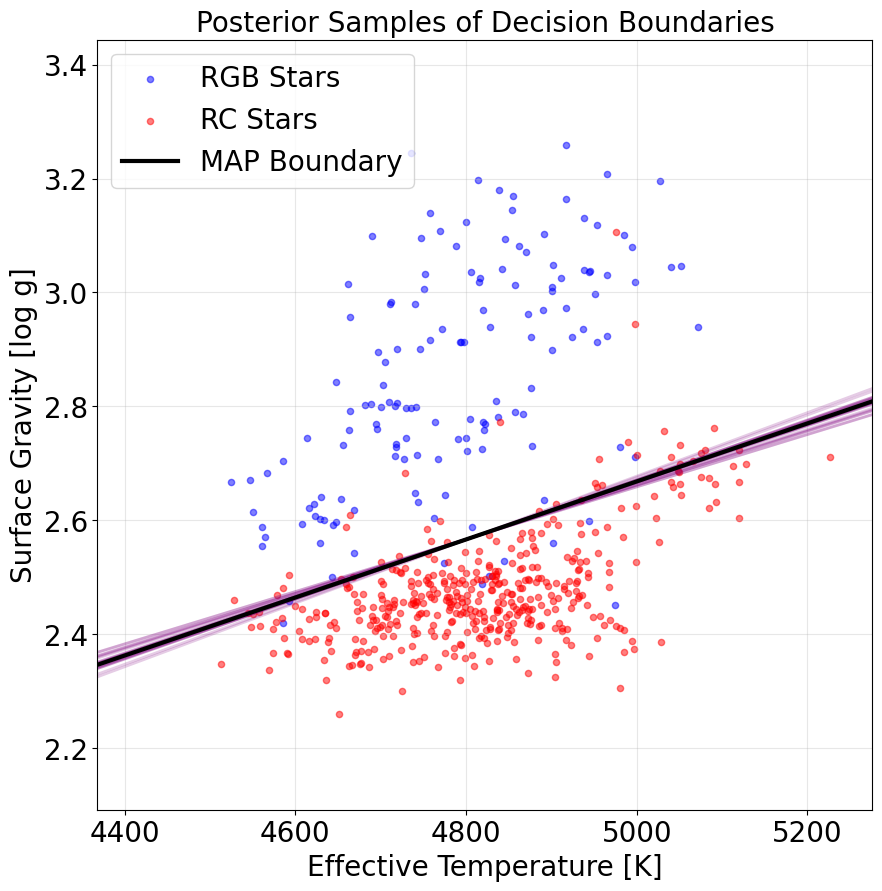

In [53]:
# Visualize multiple decision boundaries from posterior samples
plt.figure(figsize=(10, 10))

# Convert test points back to original scale for plotting
X_test_orig = X_test * X_std + X_mean

# Plot test data points
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], 
           c='blue', s=20, alpha=0.5, label='RGB Stars')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], 
           c='red', s=20, alpha=0.5, label='RC Stars')

# Create grid for decision boundaries
x_grid_orig = np.linspace(X[:, 0].min() - 100, X[:, 0].max() + 100, 100)

# Plot decision boundaries for each sampled weight vector
for i in range(len(weight_samples)):
    w_sample = weight_samples[i]
    
    # Normalize x values
    x_grid_norm = (x_grid_orig - X_mean[0]) / X_std[0]
    
    # Solve for y where decision boundary lies: w[0]*x + w[1]*y = 0
    y_grid_norm = -w_sample[0] * x_grid_norm / w_sample[1]
    
    # Convert y back to original scale
    y_grid_orig = y_grid_norm * X_std[1] + X_mean[1]
    
    # Plot sampled boundary
    plt.plot(x_grid_orig, y_grid_orig, 'purple', alpha=0.2, linewidth=2)

# Plot MAP decision boundary
y_grid_norm_map = -w_map[0] * x_grid_norm / w_map[1]
y_grid_orig_map = y_grid_norm_map * X_std[1] + X_mean[1]
plt.plot(x_grid_orig, y_grid_orig_map, 'black', linewidth=3, label='MAP Boundary')

# Customize plot
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Posterior Samples of Decision Boundaries')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(X[:, 0].min() - 50, X[:, 0].max() + 50)
plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
plt.show()

The visualization of sampled decision boundaries reveals how parameter uncertainty translates to classification uncertainty. The spread of purple lines indicates regions where the decision boundary is well-constrained versus regions of greater uncertainty. Notice how the boundaries show more variation in areas with fewer training points, particularly at the extremes of the temperature range.

To quantify this uncertainty more systematically, we can compute predictions for each sampled weight vector and examine their distribution. For any point in feature space, the variation in predictions across samples directly measures our uncertainty about its classification. Points consistently classified the same way across all samples indicate high confidence; points with varying classifications across samples warrant caution.

In [54]:
def visualize_multiple_predictions(X, w_samples):
    """
    Compute mean and standard deviation of predictions from multiple weight samples.
    
    Parameters
    ----------
    X : array
        Feature matrix (normalized)
    w_samples : array
        Samples from the posterior distribution
    
    Returns
    -------
    mean_probs : array
        Mean probabilities across samples
    std_probs : array
        Standard deviations of probabilities across samples
    """
    # Compute predictions for each weight sample
    all_probs = np.zeros((len(X), len(w_samples)))
    
    for i, w in enumerate(w_samples):
        all_probs[:, i] = sigmoid(X @ w)
    
    # Compute statistics across samples
    mean_probs = np.mean(all_probs, axis=1)
    std_probs = np.std(all_probs, axis=1)
    
    return mean_probs, std_probs

# Create normalized grid
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx_norm, yy_norm = np.meshgrid(np.linspace(x_min, x_max, 100),
                               np.linspace(y_min, y_max, 100))

# Convert to original space for plotting
xx_orig = xx_norm * X_std[0] + X_mean[0]
yy_orig = yy_norm * X_std[1] + X_mean[1]

# Prepare grid points
grid_points_norm = np.c_[xx_norm.ravel(), yy_norm.ravel()]

# Compute statistics from samples
mean_probs, std_probs = visualize_multiple_predictions(grid_points_norm, weight_samples)

# Reshape for plotting
mean_probs = mean_probs.reshape(xx_norm.shape)
std_probs = std_probs.reshape(xx_norm.shape)

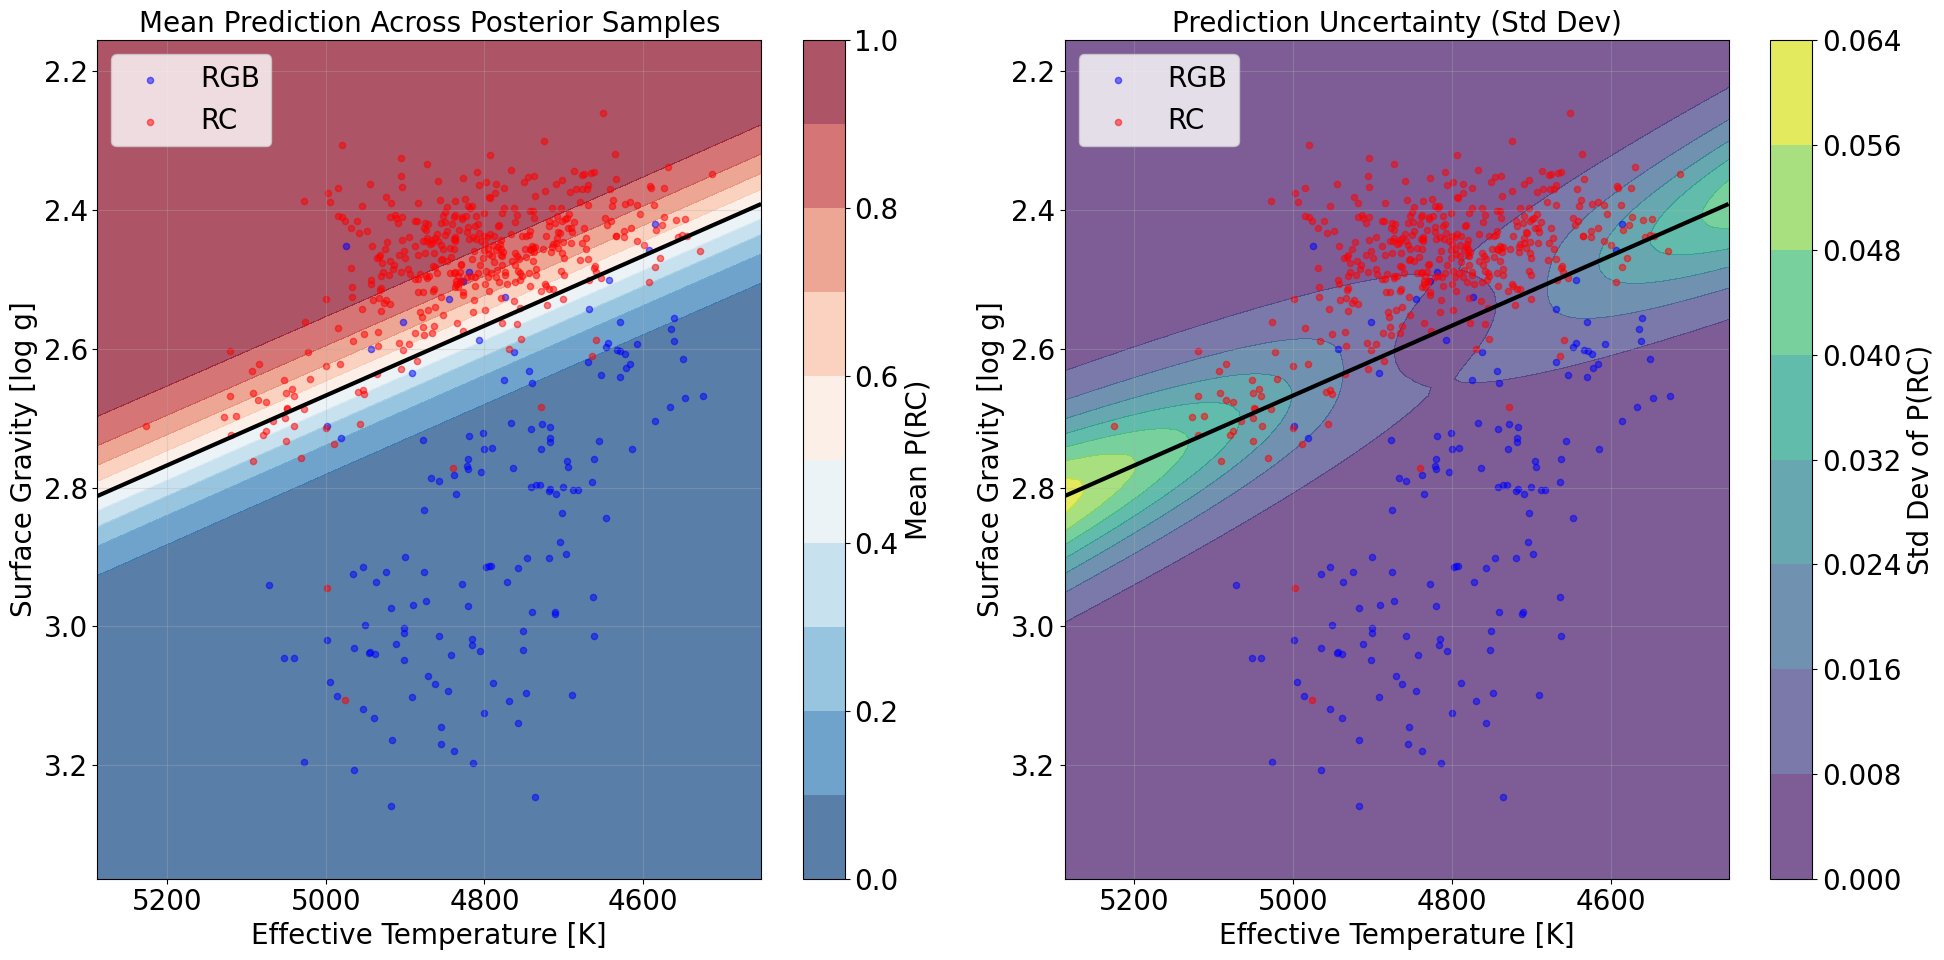

In [55]:
# Visualize mean predictions and uncertainty from posterior samples
plt.figure(figsize=(20, 10))

# Left plot: Mean prediction across samples
plt.subplot(1, 2, 1)
contour = plt.contourf(xx_orig, yy_orig, mean_probs, levels=np.linspace(0, 1, 11), 
                      cmap='RdBu_r', alpha=0.7)
plt.colorbar(contour, label='Mean P(RC)')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], 
           c='blue', s=20, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], 
           c='red', s=20, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, mean_probs, levels=[0.5], colors='black', linewidths=3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Mean Prediction Across Posterior Samples')
plt.legend()
plt.grid(True, alpha=0.3)

# Right plot: Standard deviation of predictions
plt.subplot(1, 2, 2)
uncertainty = plt.contourf(xx_orig, yy_orig, std_probs, cmap='viridis', alpha=0.7)
plt.colorbar(uncertainty, label='Std Dev of P(RC)')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], 
           c='blue', s=20, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], 
           c='red', s=20, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, mean_probs, levels=[0.5], colors='black', linewidths=3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Prediction Uncertainty (Std Dev)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## From Sample-Based to Analytical Predictions

The sampling approach provides intuitive visualizations of uncertainty, but requires generating and evaluating many samples. A more efficient approach uses the probit approximation to derive a closed-form expression for the predictive distribution. This analytical solution integrates over parameter uncertainty without explicit sampling.

For a new observation $\mathbf{x}_*$, the predictive distribution requires marginalizing over the posterior:

$$p(t_*=1|\mathbf{x}_*, \mathcal{D}) = \int \sigma(\mathbf{w}^T\mathbf{x}_*) p(\mathbf{w}|\mathcal{D}) d\mathbf{w}$$

This integral lacks a closed form due to the sigmoid function. However, the probit approximation provides an accurate solution:

$$p(t_*=1|\mathbf{x}_*, \mathcal{D}) \approx \sigma\left(\frac{\mu_a}{\sqrt{1 + \pi\sigma_a^2/8}}\right)$$

where:
- $\mu_a = \mathbf{w}_{\text{MAP}}^T \mathbf{x}_*$ is the MAP prediction
- $\sigma_a^2 = \mathbf{x}_*^T \mathbf{A}^{-1} \mathbf{x}_*$ is the variance of the linear predictor

The key insight is the uncertainty factor $\kappa = 1/\sqrt{1 + \pi\sigma_a^2/8}$. When parameter uncertainty is high (large $\sigma_a^2$), $\kappa$ becomes small, shrinking the linear predictor toward zero. This automatically pushes predictions toward 0.5—maximum uncertainty—in regions where we lack confidence in our parameters.

This mechanism provides principled uncertainty quantification: the model expresses less confidence not through ad-hoc rules but through the natural consequence of integrating over parameter uncertainty. Regions with abundant training data yield small $\sigma_a^2$, keeping $\kappa$ close to 1 and maintaining confident predictions. Sparse regions produce large $\sigma_a^2$, reducing $\kappa$ and moderating predictions appropriately.


In [56]:
def compute_predictive_distribution_probit(X, w_map, cov_matrix):
    """
    Compute Bayesian predictive distribution using the probit approximation.
    
    Parameters
    ----------
    X : array
        Feature matrix
    w_map : array
        MAP estimate of weights
    cov_matrix : array
        Covariance matrix (inverse Hessian)
        
    Returns
    -------
    pred_probs : array
        Predictive probabilities
    uncertainty : array
        Uncertainty measure (|Pred - MAP|)
    std_dev : array
        Standard deviation of linear predictor
    kappa : array
        Uncertainty factor
    """
    # Compute MAP predictions
    mu = X @ w_map
    
    # Compute prediction variance (variance of a = w^T x)
    var = np.zeros(len(X))
    for i in range(len(X)):
        x_i = X[i].reshape(-1, 1)
        var[i] = (x_i.T @ cov_matrix @ x_i)[0, 0]  # Extract scalar
    
    # Compute uncertainty factor (kappa)
    kappa = 1.0 / np.sqrt(1.0 + np.pi * var / 8.0)
    
    # Compute predictive probabilities using probit approximation
    pred_probs = sigmoid(kappa * mu)
    
    # Alternative measure of uncertainty: 
    # How much does the probability change from MAP to predictive distribution?
    map_probs = sigmoid(mu)
    uncertainty = np.abs(pred_probs - map_probs)
    
    # Also return the raw standard deviation for comparison
    std_dev = np.sqrt(var)
    
    return pred_probs, uncertainty, std_dev, kappa

In [57]:
# Create a grid for visualization
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx_norm, yy_norm = np.meshgrid(np.linspace(x_min, x_max, 100),
                              np.linspace(y_min, y_max, 100))
xx_orig = xx_norm * X_std[0] + X_mean[0]
yy_orig = yy_norm * X_std[1] + X_mean[1]

# Prepare grid points
grid_points_norm = np.c_[xx_norm.ravel(), yy_norm.ravel()]

# Compute predictive distribution using probit approximation
pred_probs, uncertainty, std_dev, kappa_values = compute_predictive_distribution_probit(
    grid_points_norm, w_map, cov_matrix
)

# Reshape for plotting
pred_probs = pred_probs.reshape(xx_norm.shape)
uncertainty = uncertainty.reshape(xx_norm.shape)
std_dev = std_dev.reshape(xx_norm.shape)
kappa_values = kappa_values.reshape(xx_norm.shape)

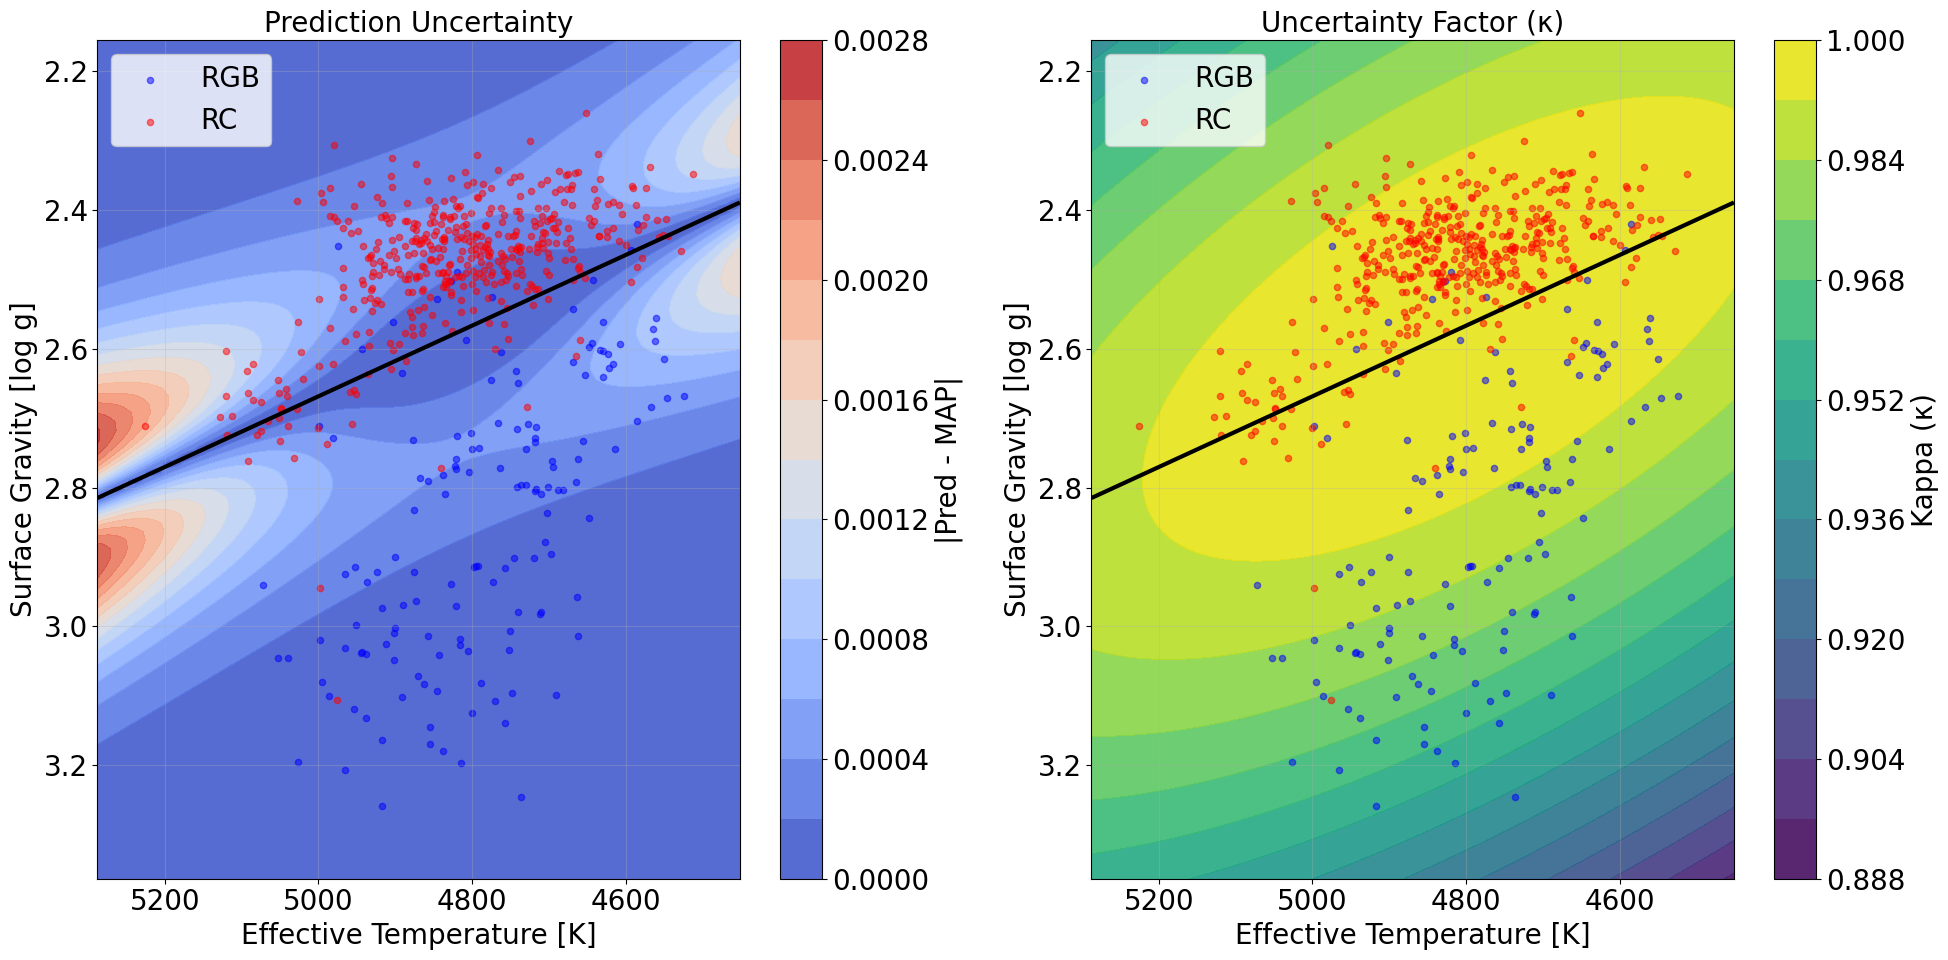

In [58]:
# Visualize prediction uncertainty and uncertainty factor (kappa)
plt.figure(figsize=(20, 10))

# Plot 1: Prediction Uncertainty
plt.subplot(1, 2, 1)
unc_plot = plt.contourf(xx_orig, yy_orig, uncertainty, cmap='coolwarm', alpha=0.9, levels=15)
plt.colorbar(unc_plot, label='|Pred - MAP|')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], 
           c='blue', s=20, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], 
           c='red', s=20, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, pred_probs, levels=[0.5], colors='black', linewidths=3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Prediction Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Kappa values with viridis color scheme
plt.subplot(1, 2, 2)
kappa_plot = plt.contourf(xx_orig, yy_orig, kappa_values, cmap='viridis', alpha=0.9, levels=15)
plt.colorbar(kappa_plot, label='Kappa (κ)')
plt.scatter(X_test_orig[t_test == 0, 0], X_test_orig[t_test == 0, 1], 
           c='blue', s=20, alpha=0.5, label='RGB')
plt.scatter(X_test_orig[t_test == 1, 0], X_test_orig[t_test == 1, 1], 
           c='red', s=20, alpha=0.5, label='RC')
plt.contour(xx_orig, yy_orig, pred_probs, levels=[0.5], colors='black', linewidths=3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g]')
plt.title('Uncertainty Factor (κ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The kappa (κ) parameter is a critical part of the probit approximation in Bayesian logistic regression. It functions as an "uncertainty factor" that modulates our predictions based on parameter uncertainty.

Let's examine two key visualizations to better understand how Bayesian logistic regression quantifies uncertainty:

1. **Prediction Uncertainty**: This shows the difference between the MAP predictions and the Bayesian predictive distribution (|Pred - MAP|). Larger values indicate areas where incorporating uncertainty has the biggest impact on our predictions.

2. **Uncertainty Factor (κ)**: This factor ranges from 0 to 1 and directly controls how much the predictions are shifted toward uncertainty. When κ is close to 1, the Bayesian predictions are similar to MAP predictions. As κ decreases, predictions are pushed toward 0.5 (maximum uncertainty).

The spatial patterns in these visualizations reveal how our model's certainty varies across the feature space.

## Understanding the Relationship Between Kappa and Prediction Changes

You might notice something counter-intuitive in our visualizations: even in regions with lower kappa values (away from the training data), the difference between Bayesian and MAP predictions remains small in many areas. This apparent discrepancy has an important mathematical explanation.

The effect of kappa depends on both:
1. The value of kappa itself (how uncertain we are)
2. The strength of the original prediction (how far from 0.5 it was)

Let's look at the probit approximation formula again:

$$p(t_*=1|\mathbf{x}_*, \mathcal{D}) \approx \sigma(\kappa \cdot \mu_a)$$

Where $\mu_a = \mathbf{w}_{\text{MAP}}^T \mathbf{x}_*$ is the logit from standard logistic regression.

For a point far from the decision boundary, $\mu_a$ might be very large in magnitude (e.g., +10 or -10). Even if kappa reduces this by 10% (κ = 0.9), the resulting value is still large enough to produce a probability very close to 0 or 1:

- Standard prediction with $\mu_a = 10$ gives $\sigma(10) \approx 0.9999$
- Bayesian prediction with $\kappa = 0.9$ gives $\sigma(0.9 \times 10) = \sigma(9) \approx 0.9999$

The impact of kappa is most noticeable:
1. **Near the decision boundary** where $\mu_a$ is close to 0
2. **When kappa is significantly lower** than 1 (much higher uncertainty)

This explains why the largest differences between MAP and Bayesian predictions appear near the decision boundary, while regions far from the boundary show minimal differences despite potentially lower kappa values.


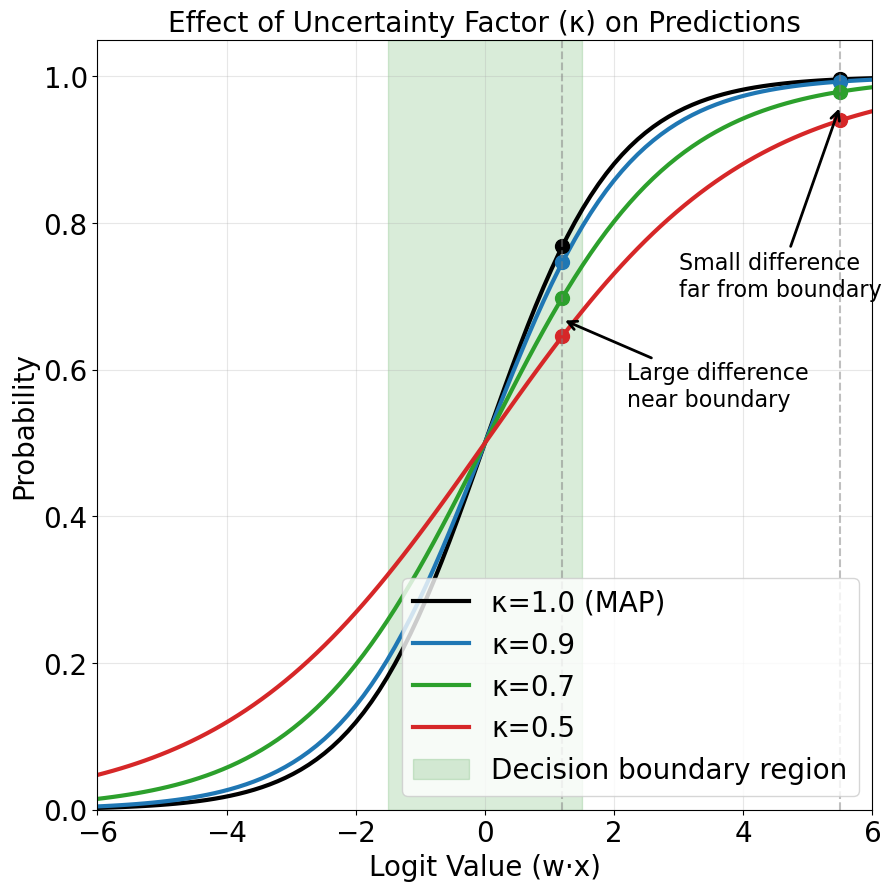

In [59]:
# Generate logit values for the x-axis
x_sigmoid = np.linspace(-6, 6, 100)
y_sigmoid = sigmoid(x_sigmoid)  # Standard sigmoid (kappa=1.0)

# Plot sigmoids with different kappa values
plt.figure(figsize=(10, 10))
kappa_values_demo = [1.0, 0.9, 0.7, 0.5]
colors = ['black', '#1f77b4', '#2ca02c', '#d62728']
labels = ['κ=1.0 (MAP)', 'κ=0.9', 'κ=0.7', 'κ=0.5']

for i, k in enumerate(kappa_values_demo):
    y_modified = sigmoid(k * x_sigmoid)
    plt.plot(x_sigmoid, y_modified, color=colors[i], linestyle='-', 
             linewidth=3, label=labels[i])

# Highlight decision boundary region
plt.axvspan(-1.5, 1.5, alpha=0.15, color='green', label='Decision boundary region')

# Mark example points
boundary_point = 1.2  # Near decision boundary
far_point = 5.5       # Far from boundary

# Calculate and mark points
boundary_ys = [sigmoid(k * boundary_point) for k in kappa_values_demo]
for i, y in enumerate(boundary_ys):
    plt.plot([boundary_point], [y], 'o', color=colors[i], markersize=10)

far_ys = [sigmoid(k * far_point) for k in kappa_values_demo]
for i, y in enumerate(far_ys):
    plt.plot([far_point], [y], 'o', color=colors[i], markersize=10)

# Add vertical lines
plt.axvline(x=boundary_point, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=far_point, color='gray', linestyle='--', alpha=0.5)

# Add annotations
plt.annotate("Large difference\nnear boundary", 
            xy=(boundary_point, boundary_ys[0] - 0.1), 
            xytext=(boundary_point + 1.0, 0.55),
            arrowprops=dict(arrowstyle="->", color='black', lw=2), 
            fontsize=16)

plt.annotate("Small difference\nfar from boundary", 
            xy=(far_point, far_ys[-1] + 0.02), 
            xytext=(far_point - 2.5, 0.7),
            arrowprops=dict(arrowstyle="->", color='black', lw=2), 
            fontsize=16)

plt.grid(True, alpha=0.3)
plt.xlabel('Logit Value (w·x)')
plt.ylabel('Probability')
plt.title('Effect of Uncertainty Factor (κ) on Predictions')
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
plt.xlim(-6, 6)
plt.show()

For RC/RGB star classification, this behavior is beneficial:
- Stars that are clearly RC or clearly RGB remain confidently classified, even when they're in regions of parameter space with higher uncertainty
- Stars near the classification boundary have their predictions appropriately moderated by uncertainty
- This reduces the chance of overconfident misclassifications in the critical transition region between RC and RGB populations

## The Effect of Prior Strength on Bayesian Logistic Regression

In Bayesian logistic regression, the prior distribution over weights plays a crucial role in both the MAP estimate and the uncertainty quantification. Let's examine how different prior strengths affect our model's behavior by comparing two cases.

The precision parameter $\alpha$ in our Gaussian prior $\mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$ controls the strength of our prior beliefs:

- A **weak prior** (small $\alpha$, e.g., 0.001) expresses little preference for particular weight values, allowing the model to be primarily guided by the data
- A **strong prior** (large $\alpha$, e.g., 1.0) strongly prefers weights close to zero, enforcing significant regularization

The prior strength affects multiple aspects of our model:

1. **MAP estimate**: Stronger priors pull weights toward zero, creating smoother decision boundaries
2. **Parameter uncertainty**: Stronger priors add additional uncertainty to our weight estimates
3. **Predictive distribution**: The combination of different MAP estimates and uncertainties produces distinct predictive behaviors

Let's compare models trained with different prior strengths to understand these effects:

In [60]:
# Compare weak vs. strong priors
alphas = [0.001, 1.0]  # Weak prior, Strong prior
prior_labels = ["Weak Prior (α=0.001)", "Strong Prior (α=1.0)"]
w_maps = []

# Train models with different prior strengths
for alpha_val in alphas:
    print(f"\nTraining model with prior strength α={alpha_val}...")
    
    # Set up training parameters
    learning_rate = 0.1
    n_epochs = 100
    batch_size = 32
    
    # Find MAP estimate with the current alpha
    w_map_current, _, _ = find_map_estimate(
        X_train, t_train, X_test, t_test, 
        learning_rate, n_epochs, batch_size, alpha_val
    )
    w_maps.append(w_map_current)
    
    print(f"MAP weights with α={alpha_val}:")
    print(f"  Temperature coefficient: {w_map_current[0]:.4f}")
    print(f"  Log g coefficient: {w_map_current[1]:.4f}")


Training model with prior strength α=0.001...
Finding MAP estimate with prior precision α=0.001...
Epoch 0: Train Loss = 0.3800, Test Loss = 0.3947
Epoch 20: Train Loss = 0.2328, Test Loss = 0.2410
Epoch 40: Train Loss = 0.2308, Test Loss = 0.2378
Epoch 60: Train Loss = 0.2306, Test Loss = 0.2372
Epoch 80: Train Loss = 0.2306, Test Loss = 0.2371
MAP weights with α=0.001:
  Temperature coefficient: 1.6293
  Log g coefficient: -5.2686

Training model with prior strength α=1.0...
Finding MAP estimate with prior precision α=1.0...
Epoch 0: Train Loss = 0.4013, Test Loss = 0.4156
Epoch 20: Train Loss = 0.3124, Test Loss = 0.3272
Epoch 40: Train Loss = 0.3127, Test Loss = 0.3273
Epoch 60: Train Loss = 0.3122, Test Loss = 0.3267
Epoch 80: Train Loss = 0.3119, Test Loss = 0.3266
MAP weights with α=1.0:
  Temperature coefficient: 0.5825
  Log g coefficient: -2.1049


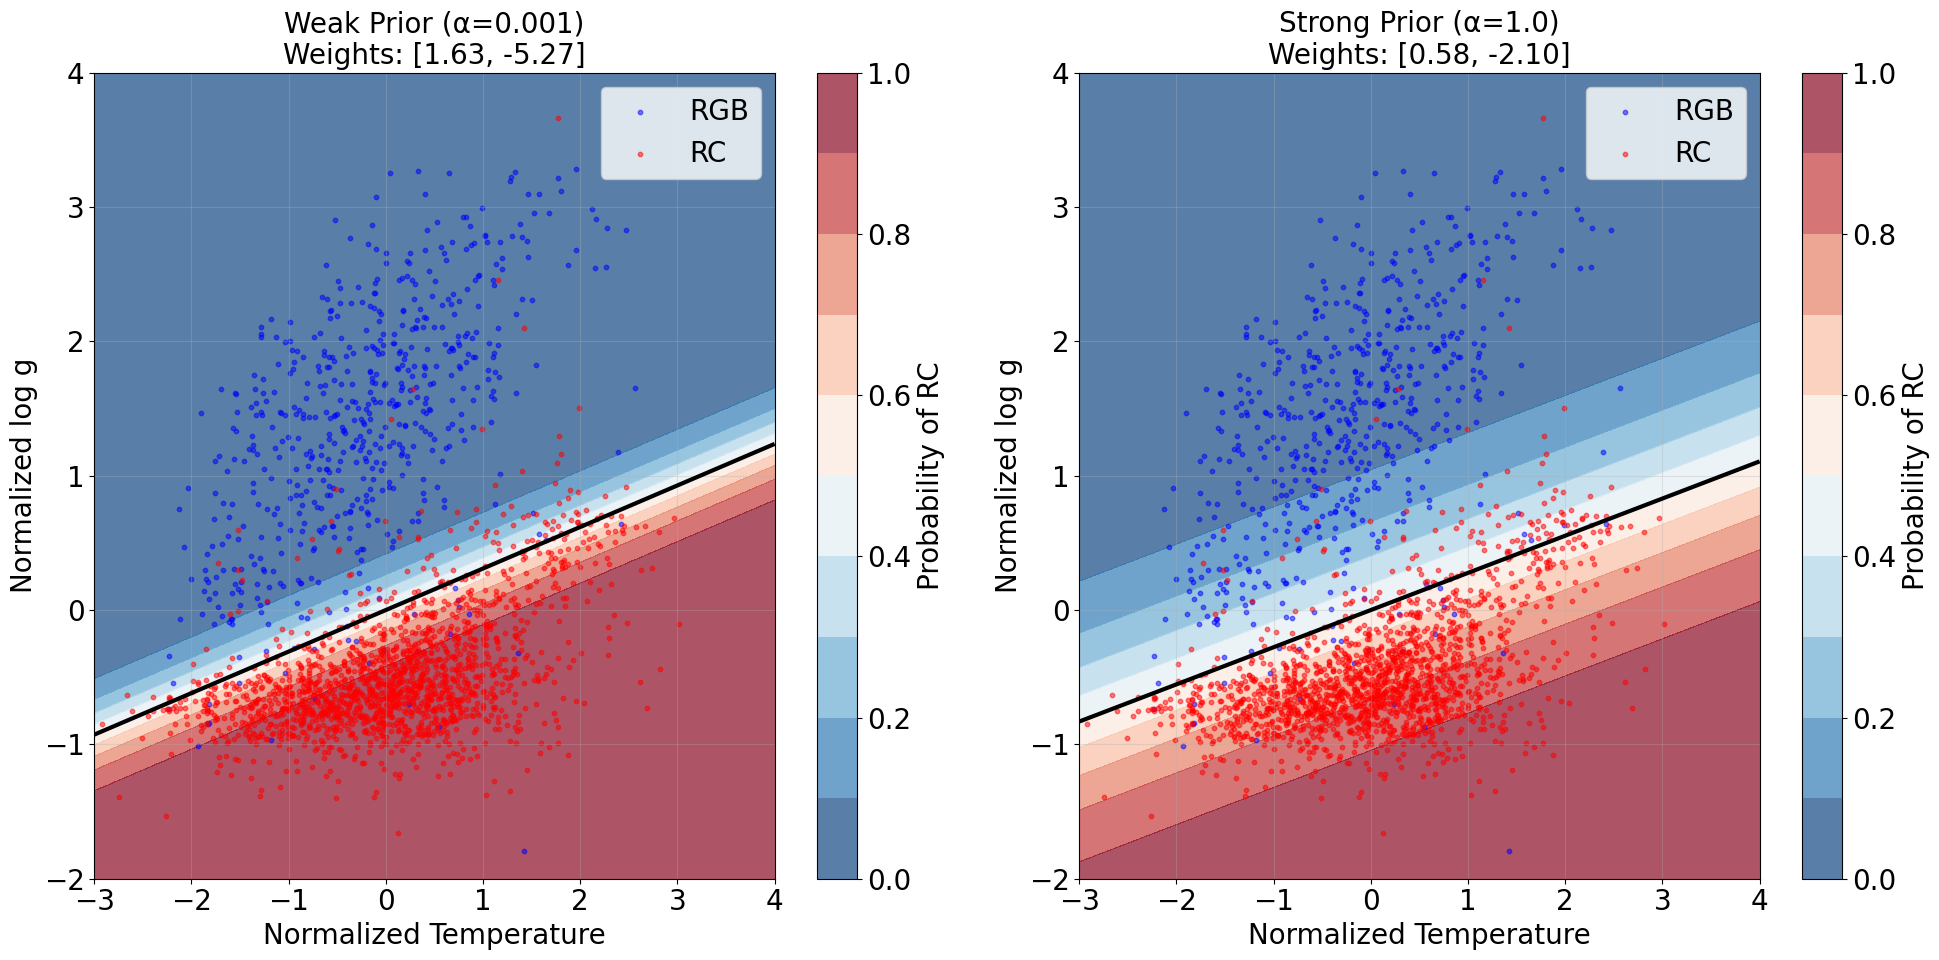

In [61]:
# Create grid in normalized feature space for visualization
x_min, x_max = -3, 4
y_min, y_max = -2, 4
xx_norm, yy_norm = np.meshgrid(np.linspace(x_min, x_max, 100),
                              np.linspace(y_min, y_max, 100))

# Create visualization comparing decision boundaries with different priors
plt.figure(figsize=(20, 10))

for i, alpha_val in enumerate(alphas):
    plt.subplot(1, 2, i+1)
    
    # Compute probabilities for grid
    grid_points = np.c_[xx_norm.ravel(), yy_norm.ravel()]
    grid_probs = sigmoid(grid_points @ w_maps[i])
    grid_probs = grid_probs.reshape(xx_norm.shape)
    
    # Create contour plot for probabilities
    contour = plt.contourf(xx_norm, yy_norm, grid_probs, levels=np.linspace(0, 1, 11), 
                           cmap='RdBu_r', alpha=0.7)
    plt.colorbar(contour, label='Probability of RC')
    
    # Plot the data points
    plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
               c='blue', s=10, alpha=0.5, label='RGB')
    plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
               c='red', s=10, alpha=0.5, label='RC')
    
    # Draw the decision boundary (probability = 0.5)
    plt.contour(xx_norm, yy_norm, grid_probs, levels=[0.5], colors='black', 
                linewidths=3, linestyles='solid')
    
    # Add title with weight values
    plt.title(f"{prior_labels[i]}\nWeights: [{w_maps[i][0]:.2f}, {w_maps[i][1]:.2f}]")
    plt.xlabel('Normalized Temperature')
    plt.ylabel('Normalized log g')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(left=-3)

plt.tight_layout()
plt.show()

The visualization reveals how prior strength affects the MAP decision boundary:

1. **Weight magnitude decreases**: With a weak prior, weights have larger magnitudes. With a strong prior, weights are pulled toward zero, resulting in smaller values.

2. **Decision boundary slope changes**: The strong prior makes the boundary less steep, representing a more balanced contribution from both features rather than being dominated by one.

3. **Probability contours widen**: With a strong prior, the transition from low to high probability becomes more gradual, reflecting the regularization effect of the prior.

These changes occur because the strong prior effectively tells the model: "Unless the data provides overwhelming evidence, prefer simpler models with smaller weights."

## Impact of Prior Strength on Uncertainty Quantification

Beyond affecting the MAP estimate, the prior strength also influences how uncertainty is quantified through the posterior distribution. Let's examine how the uncertainty factor κ varies between weak and strong priors:

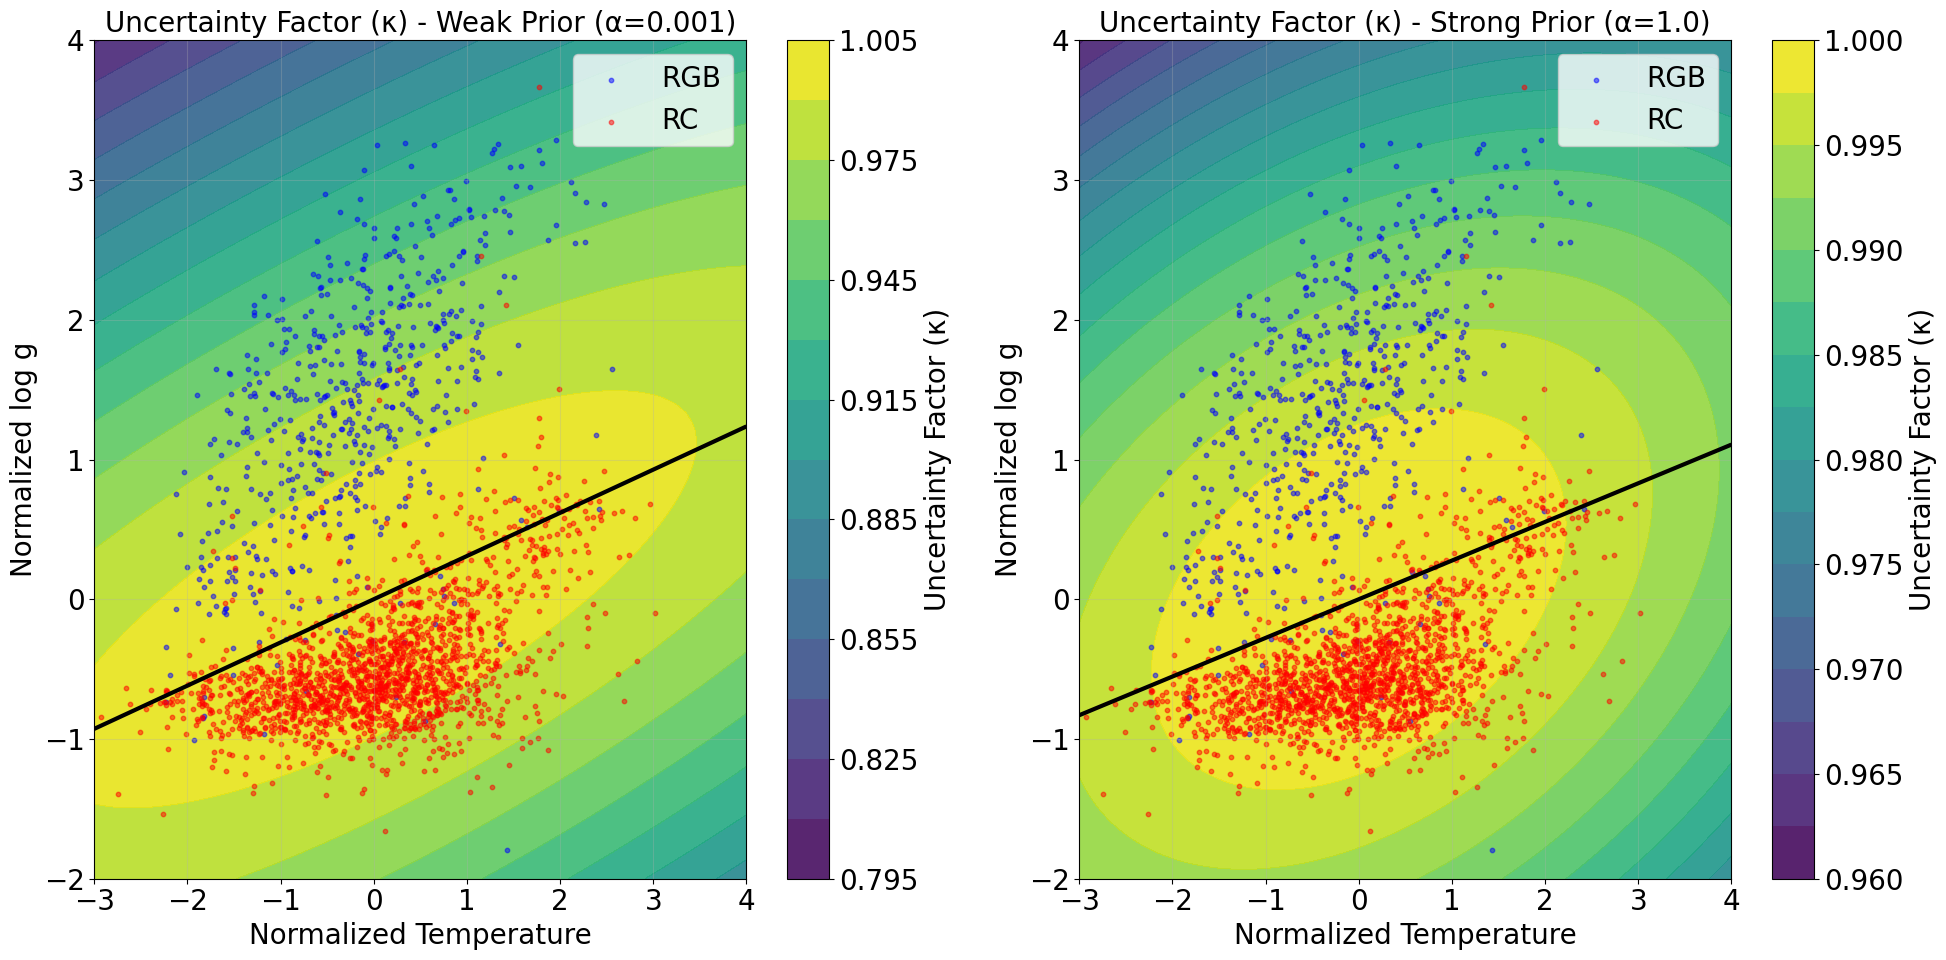

In [62]:
# Compare uncertainty factor (kappa) with weak vs. strong priors
plt.figure(figsize=(20, 10))

# For each prior strength
for i, alpha_val in enumerate(alphas):
    # Use pre-computed w_maps from earlier
    w_map_current = w_maps[i]
    
    # Compute Hessian and covariance matrix
    hessian_current = compute_hessian(w_map_current, X_train, t_train, alpha_val)
    cov_matrix_current = np.linalg.inv(hessian_current)
    
    # Compute predictive distribution using probit approximation
    _, _, _, kappa_values = compute_predictive_distribution_probit(
        grid_points, w_map_current, cov_matrix_current
    )
    
    # Reshape for plotting
    kappa_values = kappa_values.reshape(xx_norm.shape)
    
    # Create subplot
    plt.subplot(1, 2, i+1)
    
    # Plot kappa values
    kappa_plot = plt.contourf(xx_norm, yy_norm, kappa_values, 
                             cmap='viridis', alpha=0.9, levels=15)
    plt.colorbar(kappa_plot, label='Uncertainty Factor (κ)')
    
    # Plot the data points
    plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
               c='blue', s=10, alpha=0.5, label='RGB')
    plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
               c='red', s=10, alpha=0.5, label='RC')
    
    # Draw the decision boundary
    grid_probs = sigmoid(grid_points @ w_map_current)
    grid_probs = grid_probs.reshape(xx_norm.shape)
    plt.contour(xx_norm, yy_norm, grid_probs, levels=[0.5], 
               colors='black', linewidths=3, linestyles='solid')
    
    # Add title and labels
    plt.title(f"Uncertainty Factor (κ) - {prior_labels[i]}")
    plt.xlabel('Normalized Temperature')
    plt.ylabel('Normalized log g')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(left=-3)

plt.tight_layout()
plt.show()

The comparison of κ values between weak and strong priors reveals important differences:

1. **With a weak prior**: Kappa values are higher overall (closer to 1), indicating higher confidence in predictions. The model trusts the data more completely, leading to less uncertainty moderation.

2. **With a strong prior**: Kappa values are lower, especially in regions with sparse data. The model acknowledges that its predictions have been influenced by the prior rather than just the data, expressing less confidence overall.

This behavior reflects a fundamental principle of Bayesian inference: stronger priors introduce additional uncertainty into our predictions. When we impose strong beliefs through the prior, we must acknowledge that our predictions are shaped by these assumptions, not purely by the observed data. This leads to more conservative predictions that appropriately reflect both data uncertainty and prior influence.

## Comparing Bayesian and MAP Predictions Across Prior Strengths

The final piece of our analysis examines how the difference between Bayesian and MAP predictions varies with prior strength. This difference directly shows where uncertainty quantification has the most impact:

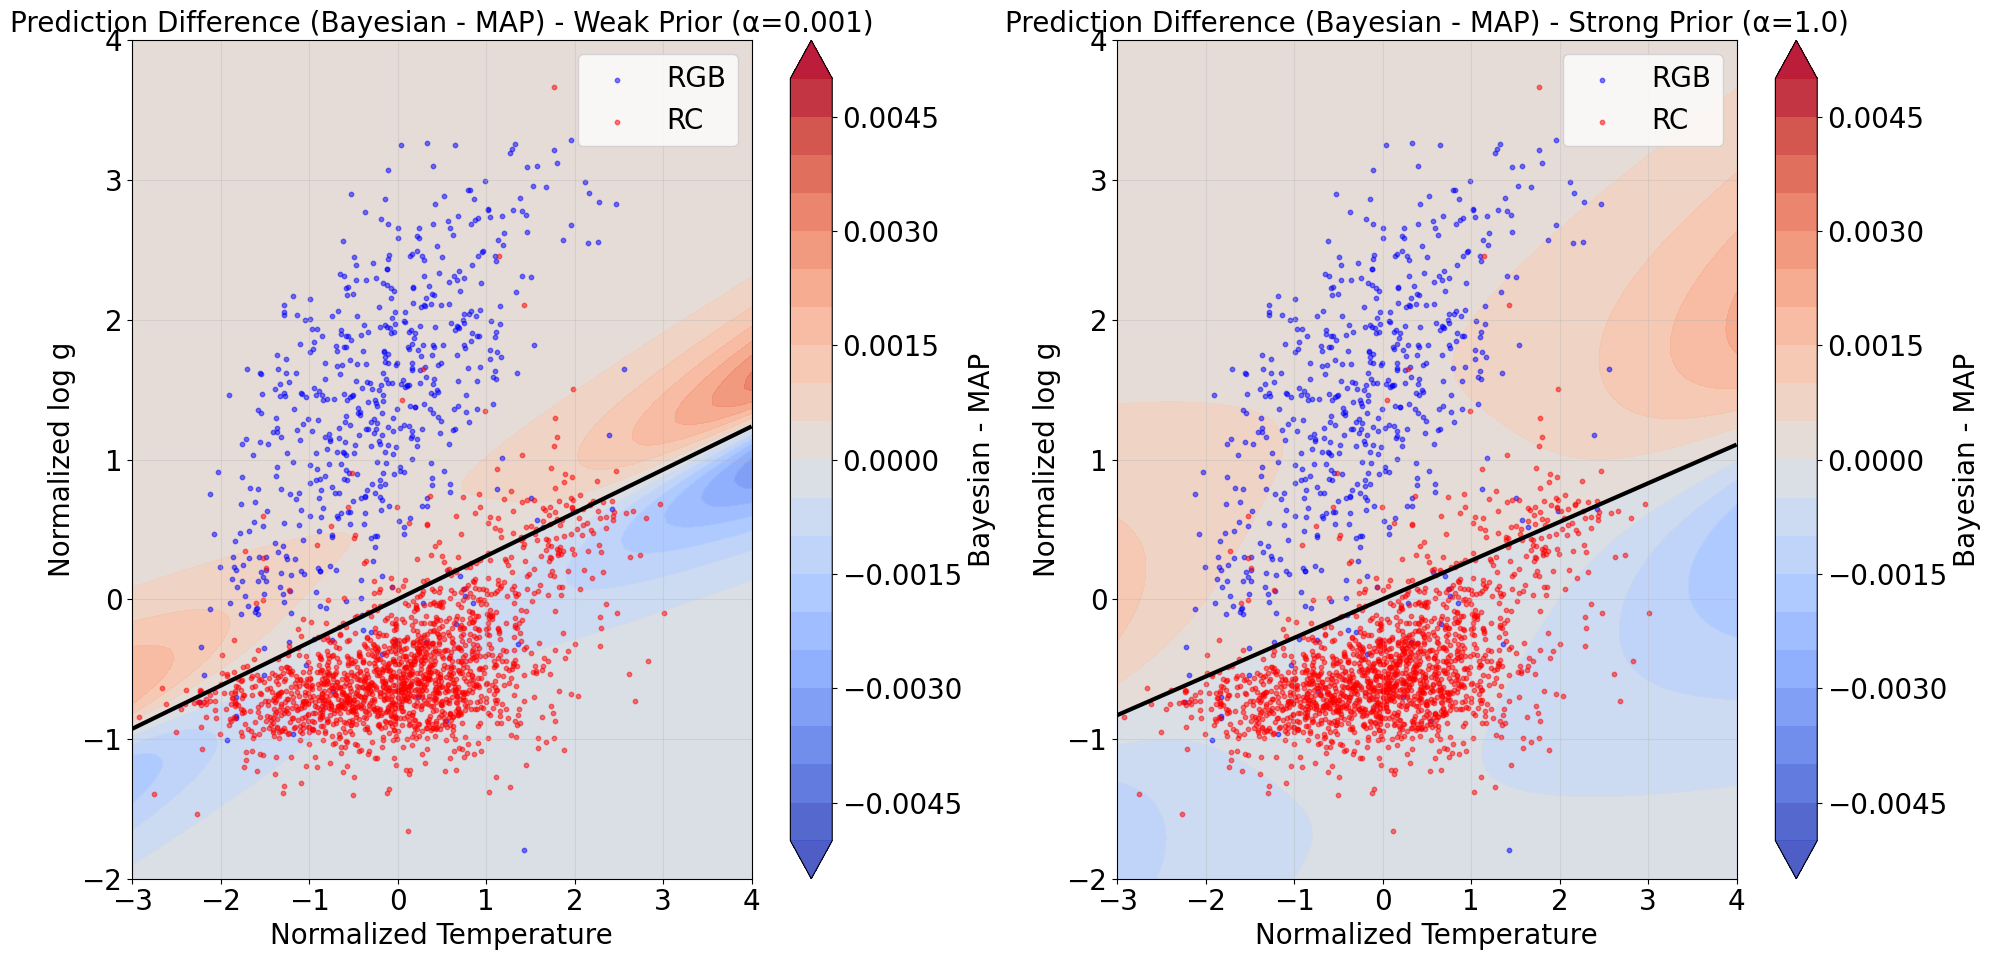

In [63]:
# Compare difference between Bayesian and MAP predictions with different priors
plt.figure(figsize=(20, 10))

# For each prior strength
for i, alpha_val in enumerate(alphas):
    # Use pre-computed w_maps from earlier
    w_map_current = w_maps[i]
    
    # Compute Hessian and covariance matrix
    hessian_current = compute_hessian(w_map_current, X_train, t_train, alpha_val)
    cov_matrix_current = np.linalg.inv(hessian_current)
    
    # Compute MAP predictions
    map_probs = sigmoid(grid_points @ w_map_current)
    
    # Compute Bayesian predictions using probit approximation
    bayes_probs, _, _, _ = compute_predictive_distribution_probit(
        grid_points, w_map_current, cov_matrix_current
    )
    
    # Calculate difference (Bayesian - MAP)
    diff_probs = bayes_probs - map_probs
    
    # Reshape for plotting
    diff_probs = diff_probs.reshape(xx_norm.shape)
    map_probs = map_probs.reshape(xx_norm.shape)
    
    # Create subplot
    plt.subplot(1, 2, i+1)
    
    # Use a narrower color range to highlight subtle differences
    vmin, vmax = -0.005, 0.005  # Narrower range to highlight differences
    
    # Plot difference between Bayesian and MAP predictions
    diff_plot = plt.contourf(xx_norm, yy_norm, diff_probs, 
                            levels=np.linspace(vmin, vmax, 21),
                            cmap='coolwarm', alpha=0.9, extend='both')
    plt.colorbar(diff_plot, label='Bayesian - MAP')
    
    # Plot the data points
    plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
               c='blue', s=10, alpha=0.5, label='RGB')
    plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
               c='red', s=10, alpha=0.5, label='RC')
    
    # Draw the decision boundary
    plt.contour(xx_norm, yy_norm, map_probs, levels=[0.5], 
               colors='black', linewidths=3, linestyles='solid')
    
    # Add title and labels
    plt.title(f"Prediction Difference (Bayesian - MAP) - {prior_labels[i]}")
    plt.xlabel('Normalized Temperature')
    plt.ylabel('Normalized log g')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(left=-3)

plt.tight_layout()
plt.show()

The comparison reveals how prior strength affects the impact of uncertainty quantification:

1. **With a weak prior**: The differences between Bayesian and MAP predictions are smaller and mostly confined to the decision boundary region. The weak prior introduces minimal additional uncertainty beyond what's inherent in the data.

2. **With a strong prior**: The differences are larger and more widespread. We see more significant modifications to the MAP predictions, particularly in regions away from dense data clusters. This reflects the additional uncertainty introduced by the strong prior.

By using a narrow color scale in our visualization, we highlight these subtle but important differences. Notice that with both priors, the differences remain most pronounced near the decision boundary, consistent with our earlier observation about the effect of kappa at different logit values. However, the strong prior creates a broader region of uncertainty modification, extending further from the decision boundary.

This behavior illustrates a key principle: stronger priors not only regularize the MAP estimate but also increase our uncertainty about predictions. This is particularly valuable in astronomical applications where we may have strong physical reasons to prefer simpler models (through regularization) while simultaneously acknowledging the additional uncertainty this preference introduces.

## Summary

In this tutorial, we've explored Bayesian logistic regression for classifying Red Clump and Red Giant Branch stars. The key insights from our analysis include:

1. **From Point Estimates to Distributions**: Unlike standard logistic regression, which provides a single optimal set of weights, Bayesian logistic regression maintains a distribution over all plausible weights, capturing parameter uncertainty.

2. **The Laplace Approximation**: By approximating the posterior distribution as Gaussian centered at the MAP estimate, we obtain a tractable framework for uncertainty quantification while maintaining computational efficiency.

3. **Predictive Distributions**: The probit approximation provides closed-form expressions for predictions that naturally integrate over parameter uncertainty, automatically moderating confidence in regions with sparse data.

4. **The Role of Uncertainty**: Through the uncertainty factor κ, the model expresses less confidence where it matters most—near decision boundaries and in regions with limited training data—while maintaining confident predictions for clearly separable populations.

5. **Prior Strength Effects**: Stronger priors not only regularize the decision boundary but also increase predictive uncertainty, reflecting the additional assumptions imposed on the model.

For astronomical classification problems, these properties prove invaluable. When RC stars serve as distance indicators, understanding classification uncertainty allows us to propagate this uncertainty through to distance estimates and ultimately to our understanding of Galactic structure. The Bayesian framework provides not just classifications but quantified confidence in those classifications—essential information for robust scientific inference.